# Import

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import clear_output
from time import sleep
import os
import pickle
from typing import List, Tuple, Dict
import chess
from tqdm import tqdm
import gc
import chess
import io
import chess.pgn
from chess.pgn import BaseVisitor
from sklearn.model_selection import train_test_split
import numpy as np

# Process data

In [2]:
df1 = pd.read_csv("../games_metadata_profile.csv")
df2 = pd.read_csv("../games_metadata_profile_2024_01.csv")


def format_game_mode(x):
    if "Classical" in x:
        return "Classical game"
    elif "Bullet" in x:
        return "Bullet game"
    elif "Blitz" in x:
        return "Blitz game"
    elif "UltraBullet" in x:
        return "UltraBullet game"
    elif "Rapid" in x:
        return "Rapid game"
    elif "Correspondence" in x:
        return "Correspondence game"
    else:
        return x


df = pd.concat([df1, df2], ignore_index=True)

df["Mode"] = df["Event"].apply(format_game_mode)

df = df[df["Mode"] == "Blitz game"]

# EDA

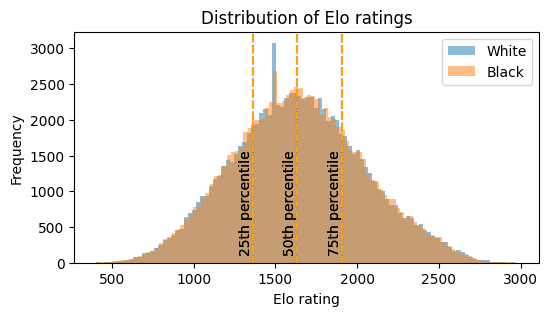

In [7]:
# Visualize the distribution of the ratings
plt.figure(figsize=(6, 3))
plt.hist(df["WhiteElo"], bins=100, alpha=0.5, label="White")
plt.hist(df["BlackElo"], bins=100, alpha=0.5, label="Black")
# draw percentile lines
for q in [0.25, 0.5, 0.75]:
    plt.axvline(df["WhiteElo"].quantile(q), color="blue", linestyle="--")
    # label the percentile lines
    plt.text(
        df["WhiteElo"].quantile(q),
        100,
        f"{q*100:.0f}th percentile",
        rotation=90,
        verticalalignment="bottom",
        horizontalalignment="right",
    )
    plt.axvline(df["BlackElo"].quantile(q), color="orange", linestyle="--")
    # label the percentile lines
    plt.text(
        df["BlackElo"].quantile(q),
        100,
        f"{q*100:.0f}th percentile",
        rotation=90,
        verticalalignment="bottom",
        horizontalalignment="right",
    )

plt.xlabel("Elo rating")
plt.ylabel("Frequency")
plt.title("Distribution of Elo ratings")
plt.legend()

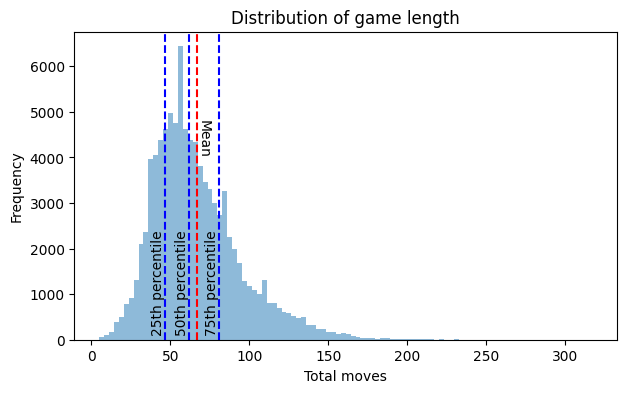

In [35]:
# Visualize the distribution of game length
plt.figure(figsize=(7, 4))
plt.hist(df["TotalMoves"], bins=100, alpha=0.5)
#  draw mean line
#   draw percentile lines
for q in [0.25, 0.5, 0.75]:
    plt.axvline(df["TotalMoves"].quantile(q), color="blue", linestyle="--")
    # label the percentile lines
    plt.text(
        df["TotalMoves"].quantile(q),
        100,
        f"{q*100:.0f}th percentile",
        rotation=90,
        verticalalignment="bottom",
        horizontalalignment="right",
    )
plt.axvline(df["TotalMoves"].mean(), color="red", linestyle="--")
plt.text(
    df["TotalMoves"].mean(),
    4000,
    "Mean",
    rotation=-90,
    verticalalignment="bottom",
    horizontalalignment="left",
)

plt.xlabel("Total moves")
plt.ylabel("Frequency")
plt.title("Distribution of game length")

plt.show()

In [3]:
df_elo_above_1800 = df[(df["WhiteElo"] + df["BlackElo"]) / 2 > 1800]
print(f"# games with average elo above 1800: {df_elo_above_1800.shape}")
del df1, df2, df
gc.collect()

# games with average elo above 1800: (31863, 34)


0

In [4]:
cutoff = 15000  # number of games to use for each partition

# set fixed seed for reproducibility
random_state = 42

df_elo_above_1800 = df_elo_above_1800.sample(cutoff, random_state=random_state)

print(f"# games with average elo above 1800: {df_elo_above_1800.shape}")

df_train, df_test = train_test_split(
    df_elo_above_1800, test_size=0.2, random_state=random_state
)

print(f"# games in train set: {df_train.shape}")
print(f"# games in test set: {df_test.shape}")

# games with average elo above 1800: (15000, 34)
# games in train set: (12000, 34)
# games in test set: (3000, 34)


# Move suggestions


In [5]:
class Visitor(BaseVisitor):
    def __init__(self):
        self.comments = []
        self.moves = []

    def visit_comment(self, comment: str) -> None:
        self.comments.append(comment)

    def visit_move(self, board: chess.Board, move: chess.Move) -> None:
        self.moves.append(move)

    def result(self):
        return self.moves, self.comments


def read_pgn(pgn):
    pgn = io.StringIO(pgn)
    moves, _ = chess.pgn.read_game(pgn, Visitor=Visitor)
    return moves

In [6]:
def load_dict(filename: str) -> Dict:
    with open(filename, "rb") as f:
        return pickle.load(f)


def save_dict(dictionary: Dict, filename: str) -> None:
    with open(filename, "wb") as f:
        pickle.dump(dictionary, f)

In [7]:
def get_move_dict(df):
    res_dict = dict()
    for _, row in tqdm(df.iterrows(), total=len(df)):
        board = chess.Board()
        moves = read_pgn(row["Moves"])
        result = row["Result"]

        for move in moves:
            board_code = " ".join(board.fen().split(" ")[:2])
            move_code = move.uci()

            if board_code not in res_dict:
                res_dict[board_code] = {}

            if move_code not in res_dict[board_code]:
                res_dict[board_code][move_code] = [0, 0, 0]  # count, win, lose

            res_dict[board_code][move_code][0] += 1

            if result == "1-0":
                if board.turn == chess.WHITE:
                    res_dict[board_code][move_code][1] += 1
                else:
                    res_dict[board_code][move_code][2] += 1
            elif result == "0-1":
                if board.turn == chess.BLACK:
                    res_dict[board_code][move_code][1] += 1
                else:
                    res_dict[board_code][move_code][2] += 1
            board.push(move)
    return res_dict

In [8]:
def suggest_move(board: chess.Board, move_dict: dict, select_mode: str = "max"):
    board_code = " ".join(board.fen().split(" ")[:2])

    if board_code not in move_dict:
        return None  # no data for this board

    if select_mode == "sampling":
        total = sum([x[0] for x in move_dict[board_code].values()])  # count
        prob = [
            x[0] / total for x in move_dict[board_code].values()
        ]  # probability distribution
        while True:
            move_code = np.random.choice(
                list(move_dict[board_code].keys()), p=prob
            )  # sample from distribution
            return chess.Move.from_uci(move_code)

    if select_mode == "max":
        ranked_moves = sorted(  # sort by count
            move_dict[board_code].items(), key=lambda x: x[1][0], reverse=True
        )
    elif select_mode == "win":
        ranked_moves = sorted(  # sort by win rate
            move_dict[board_code].items(),
            key=lambda x: x[1][1] / x[1][0] if x[1][0] > 0 else 0,
            reverse=True,
        )

    return chess.Move.from_uci(ranked_moves[0][0])

In [9]:
def suggest_move(
    board: chess.Board, move_dict: dict, select_mode: str = "sampling", src_square=None
):
    board_code = " ".join(board.fen().split(" ")[:2])

    assert select_mode in ["max", "win", "sampling"], "Invalid select_mode"
    assert src_square is None or len(src_square) == 2, "Invalid src_square"

    if board_code not in move_dict:
        return None  # no data for this board

    if select_mode == "sampling":
        if src_square:  # consider only moves from src_square
            total = sum(
                [x[0] for k, x in move_dict[board_code].items() if k[:2] == src_square]
            )
            prob = []
            choices = []
            for k, x in move_dict[board_code].items():
                if k[:2] == src_square:
                    prob.append(x[0] / total)
                    choices.append(k)
            if len(choices) == 0:
                return None  # no recorded moves starting from "src_square"
        else:
            total = sum([x[0] for x in move_dict[board_code].values()])
            prob = [
                x[0] / total for x in move_dict[board_code].values()
            ]  # probability distribution
            choices = list(move_dict[board_code].keys())

        while True:
            move_code = np.random.choice(choices, p=prob)  # sample from distribution
            return chess.Move.from_uci(move_code)

    if select_mode == "max":
        ranked_moves = sorted(  # sort by count
            move_dict[board_code].items(), key=lambda x: x[1][0], reverse=True
        )
    elif select_mode == "win":
        ranked_moves = sorted(  # sort by win rate
            move_dict[board_code].items(),
            key=lambda x: x[1][1] / x[1][0] if x[1][0] > 0 else 0,
            reverse=True,
        )
    if src_square:  # filter by source square
        ranked_moves = [x for x in ranked_moves if x[0][:2] == src_square]
    if ranked_moves == []:
        return None  # no recorded moves starting from "src_square"
    return chess.Move.from_uci(ranked_moves[0][0])

## Generate move dictionary by player's level

In [10]:
md_train_above_1800 = load_dict("data/move_dict_train_above_1800.pkl")

In [11]:
# md_train_above_1800 = get_move_dict(df_train)

# save_dict(md_train_above_1800, "data/move_dict_train_above_1800.pkl")

# Evaluation

In [12]:
# at each board setting, given a board using move_dict to predict a move and evaluate accuracy


def eval(
    test_df: pd.DataFrame,
    move_dict: dict,
    eval_mode="piece",
    select_mode="sampling",
    exclude_no_data=True,
):
    assert eval_mode in ["piece", "move", "full"], "Invalid eval_mode"
    total = 0
    correct = 0
    num_not_found = 0
    total_moves = 0
    for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
        board = chess.Board()
        moves = read_pgn(row["Moves"])
        total_moves += len(moves)

        for move in moves:
            target = move

            if eval_mode == "move":
                pred = suggest_move(
                    board,
                    move_dict,
                    select_mode,
                    src_square=target.uci()[:2],
                )
            else:
                pred = suggest_move(board, move_dict, select_mode)

            if pred:  # if no move found, skip
                if eval_mode == "piece":  # only compare source square
                    pred = pred.from_square
                    target = target.from_square
                elif eval_mode == "full":  # compare full move
                    pred = pred.uci()
                    target = target.uci()

                if pred == target:
                    correct += 1
                total += 1
            else:
                num_not_found += 1
                if exclude_no_data == False:
                    total += 1

            board.push(move)
    print(f"Number of non-existing queries: {num_not_found}")
    print(f"Number of moves evaluated: {total_moves}")
    return correct / total

In [13]:
select_mode = "max"

In [14]:
# eval(df_test, md_train_above_1800, eval_mode="piece", select_mode=select_mode) * 100

In [15]:
# eval(df_test, md_train_above_1800, eval_mode="move", select_mode=select_mode) * 100

In [16]:
# eval(df_test, md_train_above_1800, eval_mode="full", select_mode=select_mode) * 100

# Result

## Include non-existing test cases

* Sampled move
    - source square: 7.03%
    - target square: 11.37%
    - full move: 6.19%

* Majority move
    - source square: 8.25%
    - target square: 11.71%
    - full move: 7.61%

* Highest-win-rate move
    - source square: 3.83%
    - target square: 10.09%
    - full move: 3.07%

## Exclude non-existing test cases

* Non-existing ratio:
    - source square: 85.45%(186138/217822)
    - target square: 87.04%(189609/217822)
    - full move: 85.45%(186138/217822)

* Sampled move
    - source square: 47.96%
    - target square: 87.82%
    - full move: 42.87%

* Majority move
    - source square: 56.73
    - target square: 90.43%
    - full move: 52.31%

* Highest-win-rate move
    - source square: 26.29%
    - target square: 77.86%
    - full move: 21.11%

# Inference

In [31]:
def play_game(
    board: chess.Board, black_policy: dict, white_policy: dict, visualize=False
):
    while not board.is_game_over():
        if board.turn == chess.WHITE:
            move = suggest_move(board, white_policy, select_mode="sampling")
        else:
            move = suggest_move(board, black_policy, select_mode="sampling")

        if move is None:
            print("No move found")
            break

        board.push(move)

        if visualize:
            clear_output(wait=True)
            arrows = [(move.from_square, move.to_square)]
            display(chess.svg.board(board=board, size=500, arrows=arrows))
            sleep(1)

    return board.result()

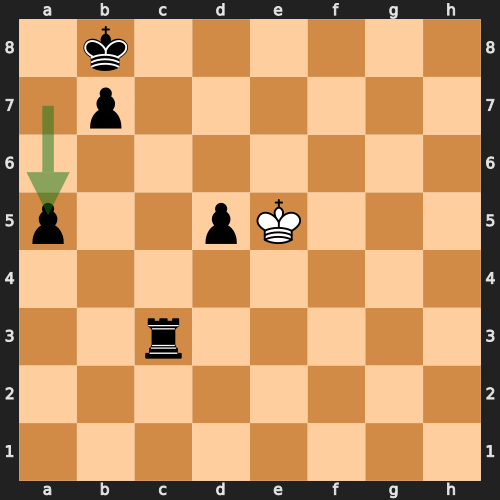

No move found


'*'

In [33]:
play_game(chess.Board(), md_train_above_1800, md_train_above_1800, visualize=True)